## Loading the Dataset

In [1]:
import os
import torchvision.datasets as datasets
from torchvision import transforms
from PIL import Image

# Define the paths for the output folders
output_root = "./"
mnist_01_path = os.path.join(output_root, "train_mnist_01")
mnist_23_path = os.path.join(output_root, "train_mnist_23")

# Create the output folders
os.makedirs(mnist_01_path, exist_ok=True)
os.makedirs(mnist_23_path, exist_ok=True)

# Load the MNIST dataset
mnist_dataset = datasets.MNIST(root="./", download=True, train=True, transform=transforms.ToTensor())

# Organize the dataset into the specified folders
for image, label in mnist_dataset:
    if label in [0, 1]:
        folder = os.path.join(mnist_01_path, f"train_image{label}_folder")
    elif label in [2, 3]:
        folder = os.path.join(mnist_23_path, f"train_image{label}_folder")
    else:
        continue  # Skip other labels

    os.makedirs(folder, exist_ok=True)
    image = transforms.ToPILImage()(image)  # Convert the image to PIL format
    image.save(os.path.join(folder, f"{label}_{len(os.listdir(folder))}.png"), "PNG")

print("MNIST dataset organized as requested.")

MNIST dataset organized as requested.


In [18]:
import os
import torchvision.datasets as datasets
from torchvision import transforms
from PIL import Image

output_root = "./"
mnist_01_path = os.path.join(output_root, "test_mnist_01")
mnist_23_path = os.path.join(output_root, "test_mnist_23")

os.makedirs(mnist_01_path, exist_ok=True)
os.makedirs(mnist_23_path, exist_ok=True)

mnist_dataset = datasets.MNIST(root="./", download=True, train=False, transform=transforms.ToTensor())
for image, label in mnist_dataset:
    if label in [0, 1]:
        folder = os.path.join(mnist_01_path, f"test_image{label}_folder")
    elif label in [2, 3]:
        folder = os.path.join(mnist_23_path, f"test_image{label}_folder")
    else:
        continue 

    os.makedirs(folder, exist_ok=True)
    image = transforms.ToPILImage()(image)  # Convert the image to PIL format
    image.save(os.path.join(folder, f"{label}_{len(os.listdir(folder))}.png"), "PNG")
print("MNIST dataset organized as requested.")

MNIST dataset organized as requested.


## Training the model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(14 * 14, 4)
        self.fc2 = nn.Linear(4, 8)
        self.fc3 = nn.Linear(8, 2)  # Two output classes (0/1 or 2/3)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def train_model(model, dataloader, num_epochs=10, learning_rate=0.0001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    accuracy_list = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total_samples = 0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        accuracy = correct / total_samples
        accuracy_list.append(accuracy)
    accuracy = np.sum(accuracy_list)/len(accuracy_list)
    

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

# Define your data transforms (you can adjust these as needed)
data_transform = transforms.Compose([
    transforms.Resize((14, 14)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Define the data loaders for the two folders
dataset_01 = ImageFolder('./train_mnist_01', transform=data_transform)
dataset_23 = ImageFolder('./train_mnist_23', transform=data_transform)

# Define data loaders
batch_size = 64
loader_01 = DataLoader(dataset_01, batch_size=batch_size, shuffle=True)
loader_23 = DataLoader(dataset_23, batch_size=batch_size, shuffle=True)

In [3]:
# test loader for client 1
test_dataset_01 = ImageFolder('D:\\Arjun Workspace\\B.Tech-Project---Federated-Learning\\Final_Demo\\testing_onMNIST\\test_mnist_01', transform=data_transform)
batch_size = 64
test_loader_01 = DataLoader(test_dataset_01, batch_size=batch_size, shuffle=True)

test_dataset_23 = ImageFolder('D:\\Arjun Workspace\\B.Tech-Project---Federated-Learning\\Final_Demo\\testing_onMNIST\\test_mnist_23', transform=data_transform)
batch_size = 64
test_loader_23 = DataLoader(test_dataset_23, batch_size=batch_size, shuffle=True)

In [4]:
model_01 = MLP()
train_model(model_01, loader_01) 

In [5]:
model_23 = MLP()
train_model(model_23, loader_23)

In [6]:
server_model = MLP()
model_01_params = model_01.state_dict()
model_23_params = model_23.state_dict()

averaged_params = {}
for key in model_01_params:
    averaged_params[key] = (model_01_params[key] + model_23_params[key]) / 2.0

server_model.load_state_dict(averaged_params)
server_model_param = server_model.state_dict()

# Save model_23 parameters to a text file
torch.save(server_model_param, 'server.txt')
# with open('D:\\Arjun Workspace\\B.Tech-Project---Federated-Learning\\Final_Demo\\testing_onMNIST\\previous_param.txt', 'w') as f:
#     for key, value in model_23_params.items():
#         f.write(f"{key}: {value}\n")

In [7]:
test_dataset = ImageFolder('D:\\Arjun Workspace\\B.Tech-Project---Federated-Learning\\Final_Demo\\testing_onMNIST\\test_mnist_01', transform=data_transform)
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [19]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(14 * 14, 4)
        self.fc2 = nn.Linear(4, 8)
        self.fc3 = nn.Linear(8, 2)  
    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_model(model, dataloader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total_samples = 0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        accuracy = correct / total_samples
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss}, Accuracy: {accuracy * 100}%")
    print("Training complete.")
    return model
    
def server_averaging(model_01, model_23):
    server_model = MLP()
    model_01_params = model_01.state_dict()
    model_23_params = model_23.state_dict()
    averaged_params = {}
    for key in model_01_params:
        averaged_params[key] = (model_01_params[key] + model_23_params[key]) / 2.0
    server_model.load_state_dict(averaged_params)
    server_model_param = server_model.state_dict()
    torch.save(server_model_param, 'server.txt')
    return server_model

def test_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def IID_simulation(local_epochs, Global_round, lr, train_loader1 , train_loader2, testloader):
    model_01 = MLP()
    model_23 = MLP()
    if os.path.isfile('server.txt'):
        model_01.load_state_dict(torch.load('server.txt'))
        model_23.load_state_dict(torch.load('server.txt'))
    for i in range(Global_round):
        w_1 = train_model(model_01, train_loader1, local_epochs, lr)
        w_2 = train_model(model_23, train_loader2, local_epochs, lr)
        w_avg = server_averaging(w_1, w_2)
        acc = test_accuracy(w_avg, testloader)
        print('Global Round: ', i+1, 'Acc: ', acc)
        with open ('accuracy.txt','a') as f:
            f.write(str(acc)+'\n')
    return acc

run = IID_simulation(2, 5, 0.00001, loader_01, loader_23, test_loader)

Epoch 1/2, Loss: 30.86661873012781, Accuracy: 98.59455191472563%
Epoch 2/2, Loss: 29.546342745423317, Accuracy: 98.69719699960521%
Training complete.
Epoch 1/2, Loss: 61.785090669989586, Accuracy: 86.45876416577053%
Epoch 2/2, Loss: 58.80772016942501, Accuracy: 87.51757796343783%
Training complete.
Global Round:  1 Acc:  99.47990543735224
Epoch 1/2, Loss: 28.336985304951668, Accuracy: 98.81563363600475%
Epoch 2/2, Loss: 27.215919487178326, Accuracy: 98.87090406632451%
Training complete.
Epoch 1/2, Loss: 56.246958285570145, Accuracy: 88.36959219124824%
Epoch 2/2, Loss: 54.00249297916889, Accuracy: 89.18851848788154%
Training complete.
Global Round:  2 Acc:  99.47990543735224
Epoch 1/2, Loss: 26.175794191658497, Accuracy: 98.94196604816423%
Epoch 2/2, Loss: 25.222236588597298, Accuracy: 98.99723647848401%
Training complete.
Epoch 1/2, Loss: 52.036369636654854, Accuracy: 89.96608487054347%
Epoch 2/2, Loss: 50.307250171899796, Accuracy: 90.61957151129126%
Training complete.
Global Round:  

In [20]:
# Make confusion matrix for model_01
server_model.eval()
confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for inputs, labels in test_loader_01:
        outputs = model_01(inputs)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(predicted)):
            confusion_matrix[labels[i], predicted[i]] += 1
print(confusion_matrix)

# Make confusion matrix for model_23
server_model.eval()
confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for inputs, labels in test_loader_23:
        outputs = model_23(inputs)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(predicted)):
            confusion_matrix[labels[i], predicted[i]] += 1
print(confusion_matrix)


tensor([[ 970.,   10.],
        [   2., 1133.]])
tensor([[745., 287.],
        [ 24., 986.]])


In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    # This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
    if normalize:
        cm = cm.numpy().astype('float') / cm.sum(axis=1, keepdim=True).numpy()
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    plt.figure(figsize=(6, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=20, horizontalalignment="center", color="red" if cm[i, j] > thresh else "red")
    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.colorbar()  # Add color bar
    plt.grid(False)
    plt.show()


In [22]:
model_01.load_state_dict(torch.load('server.txt'))

<All keys matched successfully>

Normalized confusion matrix


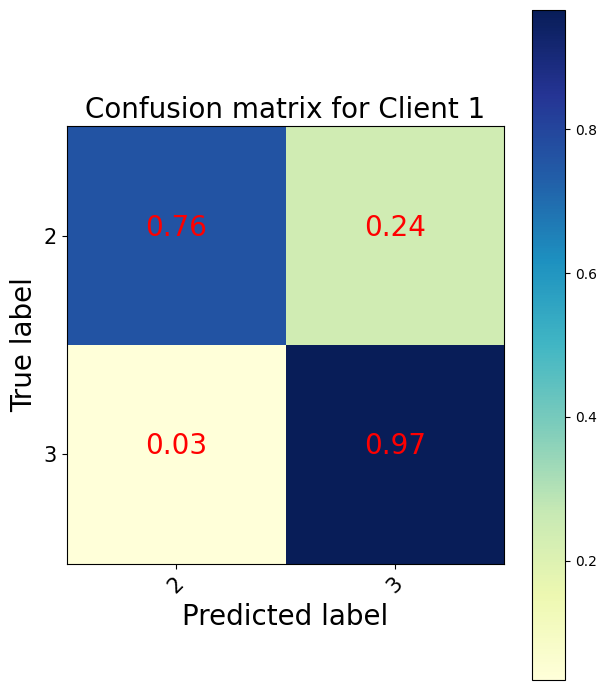

In [28]:
# Plot the confusion matrix for model_01 using the function defined above
model_01.eval()
confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for inputs, labels in test_loader_23:
        outputs = model_01(inputs)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(predicted)):
            confusion_matrix[labels[i], predicted[i]] += 1
plot_confusion_matrix(confusion_matrix, classes=["2", "3"], normalize=True, title='Confusion matrix for Client 1')

In [24]:
model_23.load_state_dict(torch.load('server.txt'))

<All keys matched successfully>

In [32]:
def train_model(model, dataloader, num_epochs=10, learning_rate=0.0001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    accuracy_list = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total_samples = 0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        accuracy = correct / total_samples
        accuracy_list.append(accuracy)
    accuracy = np.sum(accuracy_list)/len(accuracy_list)

In [33]:
mode_23 = train_model(model_23, loader_23, 2, 0.0001)

Normalized confusion matrix


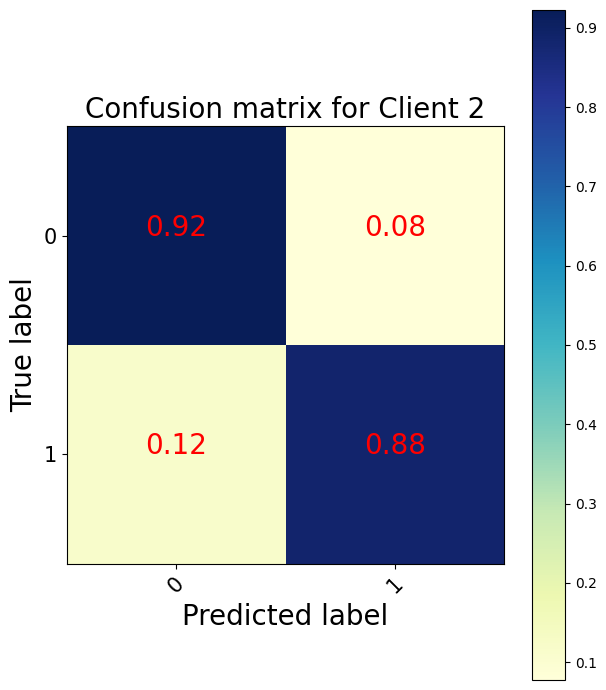

In [34]:
model_23.eval()
confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for inputs, labels in test_loader_01:
        outputs = model_23(inputs)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(predicted)):
            confusion_matrix[labels[i], predicted[i]] += 1
plot_confusion_matrix(confusion_matrix, classes=["0", "1"], normalize=True, title='Confusion matrix for Client 2')

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Set the path to your dataset directory
dataset_dir = 'train_mnist_01'

# Set the paths for the two new directories
output_dir_1 = 'client1_train_iid'
output_dir_2 = 'client2_train_iid'

# List the subdirectories (labels) in the dataset directory
labels = os.listdir(dataset_dir)

# Create the output directories if they don't exist
os.makedirs(output_dir_1, exist_ok=True)
os.makedirs(output_dir_2, exist_ok=True)

# Iterate through each label and split the data
for label in labels:
    label_dir = os.path.join(dataset_dir, label)
    output_dir_1_label = os.path.join(output_dir_1, label)
    output_dir_2_label = os.path.join(output_dir_2, label)

    # List all files in the label directory
    files = os.listdir(label_dir)

    # Split the files into two sets
    files_1, files_2 = train_test_split(files, test_size=0.5, random_state=42)

    # Create the subdirectories in the output directories
    os.makedirs(output_dir_1_label, exist_ok=True)
    os.makedirs(output_dir_2_label, exist_ok=True)

    # Copy files to the first output directory
    for file_name in files_1:
        source_path = os.path.join(label_dir, file_name)
        dest_path = os.path.join(output_dir_1_label, file_name)
        shutil.copy(source_path, dest_path)

    # Copy files to the second output directory
    for file_name in files_2:
        source_path = os.path.join(label_dir, file_name)
        dest_path = os.path.join(output_dir_2_label, file_name)
        shutil.copy(source_path, dest_path)

print("Dataset split into two directories successfully.")


Dataset split into two directories successfully.


Normalized confusion matrix


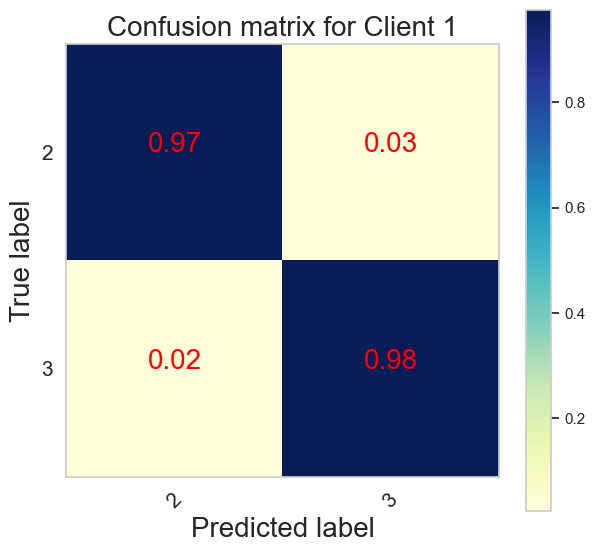

In [ ]:
# Plot the confusion matrix for model_23 using the function defined above
model_23.eval()
confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for inputs, labels in test_loader_23:
        outputs = model_23(inputs)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(predicted)):
            confusion_matrix[labels[i], predicted[i]] += 1
plot_confusion_matrix(confusion_matrix, classes=["2", "3"], normalize=True, title='Confusion matrix for Client 1')

In [ ]:
# Testing the model



In [ ]:
import os
import torch

# Define your model class (MLP) and other required components (train_model, loader_01)

params_file = "server.txt"


if os.path.getsize(params_file) == 0:
    
else:
    with open(file_path, 'r') as f:
        parameter_string = f.read()

model_01_params = model_01.state_dict()
torch.save(model_01_params, 'model_01_params.pth')  # Save the model state dictionary to a file

IndentationError: expected an indented block (333223833.py, line 11)

In [ ]:
import os
import torch


if os.path.isfile(model_01_params_file):
    model_01.load_state_dict(torch.load(model_01_params_file))
    print("Loaded model_01 parameters from file.")
else:
    print("model_01 parameters file not found. Training model_01 from scratch.")
train_model(model_01, loader_01)

# Save model_01 parameters after training
torch.save(model_01.state_dict(), model_01_params_file)

model_01_params = model_01.state_dict()
with open('model_01_params.txt', 'w') as f:
    for key, value in model_01_params.items():
        f.write(f"{key}: {value}\n")

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(14 * 14, 4)
        self.fc2 = nn.Linear(4, 8)
        self.fc3 = nn.Linear(8, 2)  

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Loading functioning

In [ ]:
import re
from collections import OrderedDict
with open('D:\\Arjun Workspace\\B.Tech-Project---Federated-Learning\\Final_Demo\\testing_onMNIST\\avg_param_temp.txt','w') as outFile:
    with open('D:\\Arjun Workspace\\B.Tech-Project---Federated-Learning\\Final_Demo\\testing_onMNIST\\client2_model.txt','r') as file:
        for line in file:
            cleaned_line = re.sub(r'\s+', ' ', line)
            outFile.write(cleaned_line)
            
with open('D:\\Arjun Workspace\\B.Tech-Project---Federated-Learning\\Final_Demo\\testing_onMNIST\\avg_param_temp.txt', 'r') as file:
    model_data = file.read()
    # print(model_data)

model_data = model_data.replace(' ', '')
model_data = model_data.replace('tensor', '')

lines = model_data.strip().split('\n')
model = MLP()
model_dict = OrderedDict()
keys=[]
values=[]
model_ls = model_data.split(':')
keys.append(model_ls[0])
for i in model_ls[1:-1]:
    value , key = i[1:].split(')')
    values.append(eval(value))
    keys.append(key)
    
values.append(eval(model_ls[-1]))
print(len(keys),len(values))
for i in range(len(keys)):
    model_dict[keys[i]] = torch.FloatTensor(values[i])
parameter = model_dict
model.load_state_dict(parameter)

6 6


<All keys matched successfully>

In [4]:
from matplotlib import pyplot as plt

def read_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            data.append(float(line.strip()))
    return data

def plot_data(data, title):
    x = range(1, len(data) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(x, data, marker='o', linestyle='-', color='b')  # 'o' for markers, '-' for line, 'b' for blue color
    # change figsize
    
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.xticks(x)
    plt.show()

file_path1 = 'D:\\Arjun Workspace\\B.Tech-Project---Federated-Learning\\Final_Demo\\testing_onMNIST\\accuracy.txt'
data = read_data(file_path1)
plot_data(data, 'Accuracy Plot ')

ValueError: could not convert string to float: ''

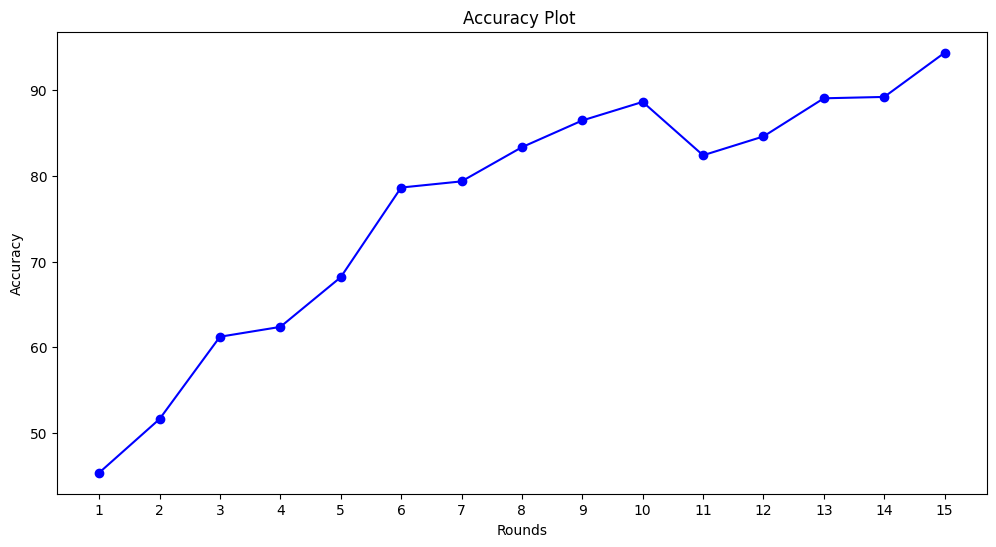

In [1]:
from matplotlib import pyplot as plt

def read_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            data.append(float(line.strip()))
    return data

def plot_data(data, title):
    x = range(1, len(data) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(x, data, marker='o', linestyle='-', color='b')  # 'o' for markers, '-' for line, 'b' for blue color
    # change figsize
    
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.xticks(x)
    plt.show()

file_path1 = 'D:\\Arjun Workspace\\B.Tech-Project---Federated-Learning\\Final_Demo\\testing_onMNIST\\accuracy.txt'
data = read_data(file_path1)
plot_data(data, 'Accuracy Plot ')

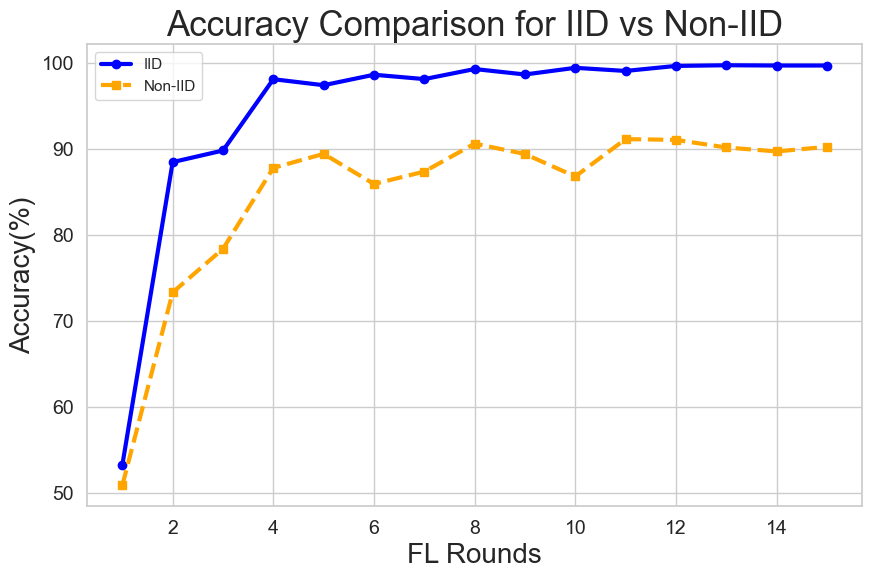

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

file1 = 'D:\\Arjun Workspace\\B.Tech-Project---Federated-Learning\\Final_Demo\\testing_onMNIST\\accuracy2.txt'
data1 = np.loadtxt(file1) # 5 db
file2 = 'D:\\Arjun Workspace\\B.Tech-Project---Federated-Learning\\Final_Demo\\testing_onMNIST\\accuracy3.txt'
data2 = np.loadtxt(file2) # 10 db
# file3 = 'D:\\Arjun Workspace\\B.Tech-Project---Federated-Learning\\Final_Demo\\testing_onMNIST\\accuracy4.txt'
# data3 = np.loadtxt(file3) # 15 db

rounds = np.arange(1, len(data1) + 1)


plt.figure(figsize=(10, 6))


plt.plot(rounds, data2, marker='o', linestyle='-', color='blue', linewidth=3 ,label='IID')
plt.plot(rounds, data1, marker='s', linestyle='--', color='orange',linewidth=3, label='Non-IID')
# plt.plot(rounds, data3, marker='^', linestyle='-.', color='green',linewidth=3, label='Power at 15dB')

plt.title('Accuracy Comparison for IID vs Non-IID', fontsize=25)
plt.xlabel('FL Rounds', fontsize=20)
plt.ylabel('Accuracy(%)', fontsize=20)
plt.legend(loc='upper left')  # Adjust the location of the legend

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)  # Show grid lines
plt.show()

testing accuracy

In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    
    data_transform = transforms.Compose([
        transforms.Resize((14, 14)), 
        transforms.Grayscale(num_output_channels=1),  
        transforms.ToTensor(),
    ])
    
test_dataset = ImageFolder('D:\\Arjun Workspace\\B.Tech-Project---Federated-Learning\\Final_Demo\\testing_onMNIST\\test_mnist_01', transform=data_transform)
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_accuracy = test_model(model, test_loader)
with open ('D:\\Arjun Workspace\\B.Tech-Project---Federated-Learning\\Final_Demo\\testing_onMNIST\\accuracy1.txt','a') as f:
    f.write(str(test_accuracy)+'\n')

NameError: name 'model' is not defined

In [ ]:
test_dataset = ImageFolder('D:\\Arjun Workspace\\B.Tech-Project---Federated-Learning\\Final_Demo\\testing_onMNIST\\test_mnist_01', transform=data_transform)
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
param_dict = model.state_dict()

In [ ]:
with open ('avg_param.txt', 'r') as f:
    model_01_params = f.read()
    avg_model = MLP()

fc1.weight: tensor([[ 5.7930e+00, -1.8262e+00,  4.8316e+00,  4.5749e+00,  4.3979e-01,
          3.7510e+00,  4.4334e+00,  3.1322e+00,  3.6518e+00, -8.8221e-02,
         -1.6226e-01,  4.9976e+00,  4.8407e+00, -1.7169e+00,  1.2888e+00,
          2.5967e+00,  2.7355e+00,  2.4330e+00, -4.3462e-01, -1.1524e+00,
          3.9498e-01,  4.6351e-01,  1.6828e-01,  3.7502e-01,  1.0994e+00,
          3.5127e+00,  1.6716e+00,  2.3046e+00, -3.2535e-01, -7.3161e-01,
          2.4532e+00,  1.7679e+00,  3.5677e+00,  3.2606e+00, -1.0433e+00,
         -6.7723e-01, -1.0546e+00, -1.3392e+00,  4.2582e+00, -2.2565e-02,
          4.5445e+00,  2.7184e+00,  2.8057e+00,  5.0856e-01, -1.3046e-01,
         -1.0228e+00,  1.4435e+00,  1.4487e+00,  1.5161e+00, -5.7030e-01,
         -5.4805e-01, -3.6782e-01, -8.6521e-01, -7.1516e-01, -3.3556e-02,
          3.9670e+00,  3.2091e+00,  9.5274e-01, -6.0381e-01, -5.0579e-01,
         -1.0488e+00,  3.1525e+00,  3.4532e+00, -8.0019e-01,  3.2077e+00,
         -1.2643e+00,  1.8

In [ ]:
import os
model_23 = MLP()

train_model(model_23, loader_23)
model_23_params = model_23.state_dict()

In [ ]:
model_23_params_dummy = {}
for i,j in model_23_params.items():
    model_23_params_dummy[i] = j.cpu().numpy().tolist()

In [ ]:
model_23_params_dummy

{'fc1.weight': [[-0.057589806616306305,
   0.041093312203884125,
   0.03574781119823456,
   -0.0079110786318779,
   0.038658834993839264,
   -0.0023260661400854588,
   0.14069437980651855,
   0.14325152337551117,
   0.1357535868883133,
   0.1604781448841095,
   0.10457038134336472,
   0.030854463577270508,
   0.03015386313199997,
   -0.023604419082403183,
   0.04813035577535629,
   0.055000048130750656,
   0.06605904549360275,
   -0.028219161555171013,
   0.07548832148313522,
   0.13231565058231354,
   0.32884681224823,
   0.2716536819934845,
   0.18318097293376923,
   0.149532750248909,
   0.0995865911245346,
   0.11613734811544418,
   0.0338873490691185,
   -0.022772084921598434,
   0.025213954970240593,
   0.03770333155989647,
   0.05024069920182228,
   0.048146799206733704,
   0.15684184432029724,
   0.08756329119205475,
   0.2000913918018341,
   0.07210814952850342,
   0.014764935709536076,
   0.0645887479186058,
   0.28787675499916077,
   0.2752452790737152,
   0.1546277552843094

In [ ]:
import json

In [ ]:
with open("sample.json", "w") as outfile: 
    json.dump(model_23_params_dummy, outfile)

In [ ]:
with open('sample.json') as json_file:
    data = json.load(json_file)
    for i in data.keys():
        data[i] = torch.tensor(data[i])

In [ ]:
data

{'fc1.weight': tensor([[-5.7590e-02,  4.1093e-02,  3.5748e-02, -7.9111e-03,  3.8659e-02,
          -2.3261e-03,  1.4069e-01,  1.4325e-01,  1.3575e-01,  1.6048e-01,
           1.0457e-01,  3.0854e-02,  3.0154e-02, -2.3604e-02,  4.8130e-02,
           5.5000e-02,  6.6059e-02, -2.8219e-02,  7.5488e-02,  1.3232e-01,
           3.2885e-01,  2.7165e-01,  1.8318e-01,  1.4953e-01,  9.9587e-02,
           1.1614e-01,  3.3887e-02, -2.2772e-02,  2.5214e-02,  3.7703e-02,
           5.0241e-02,  4.8147e-02,  1.5684e-01,  8.7563e-02,  2.0009e-01,
           7.2108e-02,  1.4765e-02,  6.4589e-02,  2.8788e-01,  2.7525e-01,
           1.5463e-01, -3.7953e-02, -2.4626e-02,  1.9775e-01,  1.5530e-01,
           1.4922e-02, -6.0985e-03, -1.4569e-02,  3.6448e-02,  4.3750e-02,
           9.0725e-03,  4.4111e-02,  1.0008e-01,  1.4579e-01,  3.4363e-02,
          -1.6365e-01, -6.2442e-02,  2.0421e-01,  1.5209e-01,  5.9130e-02,
           1.1771e-02, -2.6804e-02,  9.0822e-02,  1.0317e-01,  8.9781e-02,
           

In [ ]:
state_dict = model_23.state_dict()
# jump this state-dict into test.txt file


In [ ]:
server_model = MLP()
model_01_params = model_01.state_dict()
model_23_params = model_23.state_dict()

averaged_params = {}
for key in model_01_params:
    averaged_params[key] = (model_01_params[key] + model_23_params[key]) / 2.0

server_model.load_state_dict(averaged_params)
server_model_param = server_model.state_dict()

with open('server.txt', 'w') as f:
    for key, value in server_model_param.items():
        f.write(f"{key}: {value}\n")

In [ ]:
print(server_model_param)

OrderedDict([('fc1.weight', tensor([[-5.0127e-02,  1.8536e-02, -1.9727e-02,  9.0329e-03,  1.6784e-02,
         -1.7825e-02,  2.7559e-02,  3.8793e-02,  8.7893e-02,  8.2725e-03,
         -2.2106e-03,  2.4475e-02, -2.1004e-02,  3.2130e-02,  5.3172e-02,
          5.1522e-02,  4.3838e-02,  2.7221e-02,  2.9050e-02,  2.5176e-02,
          1.1861e-01,  9.4062e-02,  5.4729e-02,  3.1546e-02,  1.0668e-01,
          6.5202e-02,  1.1875e-02, -1.9791e-02,  6.3679e-02, -2.9061e-02,
         -1.5746e-02,  4.1940e-02,  5.1494e-02,  7.7557e-02,  7.5152e-02,
          7.9142e-02,  4.7510e-02, -2.7851e-02,  1.0693e-01,  1.0510e-01,
          1.1948e-01, -1.4963e-03,  7.2934e-02, -2.6519e-03,  7.9805e-02,
          1.0640e-01,  4.0554e-02,  8.3181e-03,  6.4928e-02,  1.6268e-02,
         -7.7924e-04,  1.3985e-02,  6.5923e-02,  2.5864e-02,  2.4130e-02,
         -3.3447e-02, -1.3817e-02,  2.3500e-02, -1.9039e-02, -4.0491e-03,
          3.9094e-02,  2.7835e-02,  4.2720e-02,  1.0247e-01,  7.2844e-02,
         -

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(14 * 14, 4)
        self.fc2 = nn.Linear(4, 8)
        self.fc3 = nn.Linear(8, 2)  
    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_model(model, dataloader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total_samples = 0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        accuracy = correct / total_samples
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss}, Accuracy: {accuracy * 100}%")
    print("Training complete.")
    return model
    
def server_averaging(model_01, model_23):
    server_model = MLP()
    model_01_params = model_01.state_dict()
    model_23_params = model_23.state_dict()
    averaged_params = {}
    for key in model_01_params:
        averaged_params[key] = (model_01_params[key] + model_23_params[key]) / 2.0
    server_model.load_state_dict(averaged_params)
    server_model_param = server_model.state_dict()
    torch.save(server_model_param, 'server.txt')
    return server_model

def test_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def IID_simulation(local_epochs, Global_round, lr, train_loader1 , train_loader2, testloader):
    model_01 = MLP()
    model_23 = MLP()
    if os.path.isfile('server.txt'):
        model_01.load_state_dict(torch.load('server.txt'))
        model_23.load_state_dict(torch.load('server.txt'))
    for i in range(Global_round):
        w_1 = train_model(model_01, train_loader1, local_epochs, lr)
        w_2 = train_model(model_23, train_loader2, local_epochs, lr)
        w_avg = server_averaging(w_1, w_2)
        acc = test_accuracy(w_avg, testloader)
        print('Global Round: ', i+1, 'Acc: ', acc)
        with open ('accuracy.txt','a') as f:
            f.write(str(acc)+'\n')
    return acc

run = IID_simulation(2, 10, 0.0001, loader_01, loader_23, test_loader)

UnpicklingError: invalid load key, 'f'.

In [ ]:
import ast
from collections import OrderedDict

# Example model_data string (modify it to match your actual data)
model_data = """
OrderedDict([('fc1.weight', [
  [0.0505, -0.0440, -0.0428, -0.0562, 0.0127, 0.0297, -0.0456, -0.0519],
  [0.0228, 0.0297, -0.0123, -0.0267, -0.0446, 0.0131, -0.0200, 0.0060]
]),
('fc1.bias', [0.0192, 0.0177, -0.0354, -0.0568]),
('fc2.weight', [
  [0.1537, -0.3202, 0.4948, -0.0773],
  [0.3002, -0.0811, -0.3692, 0.0369]
]),
('fc2.bias', [-0.2434, -0.2540, -0.0467, -0.3672, -0.3011, -0.3156, 0.2804, -0.2091]),
('fc3.weight', [
  [0.1913, 0.1333, 0.0441, 0.2326, 0.2679, 0.0759, -0.0270, -0.0785],
  [-0.2917, -0.0671, 0.1286, -0.1122, -0.1880, -0.1270, 0.0533, -0.1485]
]),
('fc3.bias', [0.3187, 0.2971])
])
"""

# Convert the model_data string to an OrderedDict
model_dict = ast.literal_eval(model_data)

# Ensure that the result is an OrderedDict
if isinstance(model_dict, OrderedDict):
    print("Successfully converted model_data to an OrderedDict.")
else:
    print("Conversion to OrderedDict failed.")


In [ ]:
import json
import torch

# Function to convert model parameters to a string
def parameters_to_string(model):
    state_dict = model.state_dict()
    serializable_state_dict = {}
    for key, value in state_dict.items():
        if isinstance(value, torch.Tensor):
            value = value.tolist()
        serializable_state_dict[key] = value

    state_dict_json = json.dumps(serializable_state_dict)
    return state_dict_json

# Function to load model parameters from a string
def string_to_parameters(json_string, model):
    serializable_state_dict = json.loads(json_string)
    state_dict = {}
    for key, value in serializable_state_dict.items():
        if key in model.state_dict():
            state_dict[key] = torch.tensor(value)

    model.load_state_dict(state_dict)
    return model

# print model parameters in string format
print(parameters_to_string(model_01))
len(parameters_to_string(model_01))